Link to article containing original code: <url>https://cnvrg.io/pytorch-lstm/</url><br>
Most of the code is different due to mistakes present in original code.

In [163]:
# imports
import torch as torch
import torch.nn as nn
from torch.autograd import Variable 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import trange
import json

In [164]:
# variable that determines whether results should be saved
save = True

In [165]:
# read monthly processed data
df = pd.read_csv('../../dataframes/monthly_processed.csv', index_col='date', parse_dates=True)
df_prices = df['fishoil_price_peru_value']
df = df.drop('fishoil_price_peru_value', axis=1)

# # read weekly processed data with juveniles
# df = pd.read_csv('../../dataframes/weekly_processed.csv', index_col='date', parse_dates=True)
# df_prices = df['fishoil_price_peru_value']
# df = df.drop('fishoil_price_peru_value', axis=1)

# # read weekly processed data with juveniles
# df = pd.read_csv('../../dataframes/weekly_processed_with_juveniles.csv', index_col='date', parse_dates=True)
# df_prices = df['fishoil_price_peru_value']
# df = df.drop('fishoil_price_peru_value', axis=1)

In [166]:
# # filter some of the features of the data
# df = df[['fishoil_price_peru', 'fish_price_global', 'rapeseedoil_price_global', 'fishmeal_price_peru', 'temperature_peru', 'precipitation_peru', 'fish_production_peru', 'fishoil_export_peru']]

In [167]:
# look for how many years we have all the features in total
df

,fishoil_price_peru,fish_price_global,rapeseedoil_price_global,fishmeal_price_peru,peanutoil_price_global,soybeanoil_price_global,sunfloweroil_price_global,temperature_peru,precipitation_peru,fish_production_peru,fish_human_consumption_peru,fish_industrial_consumption_peru,gdp,fishmeal_price_hamburg,fishoil_export_peru,fishoil_fob_peru,fishoil_utilization_indicators,fishing_hours_peru
date,,,,,,,,,,,,,,,,,,
2022-06-01,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-05-01,0.000000,0.0,0.103397,0.016131,0.000047,0.113792,0.098321,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012453,0.000000,0.000000,0.000000,0.000000
2022-04-01,0.000000,0.0,0.021282,0.005602,-0.000485,-0.007861,0.090283,0.000000,0.000000,-0.039221,0.197565,-3.712563,-1.172411,-0.012958,0.000000,0.000000,-3.693340,0.028711
2022-03-01,0.000000,0.0,-0.046919,-0.081597,0.003676,0.004800,0.036826,0.000000,0.000000,-0.020203,-0.071978,0.349140,0.035878,-0.026608,0.000000,0.000000,0.325054,0.131319
2022-02-01,0.000000,0.0,-0.214876,-0.046882,0.138541,-0.204014,-0.454262,0.000000,0.000000,-0.020619,-0.062978,0.114717,0.213405,-0.020735,0.000000,0.000000,0.095745,0.016566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1985-05-01,0.001269,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.051774,0.527306,0.000000,0.000000,0.000000,0.000000,0.000000,1.396245,1.386294,0.000000,0.000000
1985-04-01,-0.343536,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.025439,-0.039544,0.000000,0.000000,0.000000,0.000000,0.000000,1.686582,1.338285,0.000000,0.000000
1985-03-01,-0.049483,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.062869,0.229165,0.000000,0.000000,0.000000,0.000000,0.000000,-0.234435,-0.282232,0.000000,0.000000


In [168]:
# variable definitions
num_epochs = 50                 # number of epochs
learning_rate = 0.001           # 0.001 lr

seq_length = 36                 # sequence length of sequence given to the LSTM layer
pred_length = 12                # prediction length of output sequence produced by LSTM layer 
                                # (multiples of twelve since there is yearly seasonality)
                                
input_size = len(df.columns)    # number of features (amount of input variables)
output_size = 1                 # size of output (peru fish oil price so just one variable)
hidden_size = 32                # number of features in hidden state (this number should be treated as a hyperparameter)
num_layers = 2                  # number of stacked lstm layers
dropout = 0                     # probability for dropout cells

num_classes = pred_length       # number of output classes 

In [169]:
# function to create list of sequences of length seq_length
def create_series(data, data_prices, target):
    # the amount of time-steps for which we have data
    total_timesteps = len(data)

    # arrays that hold the input sequences and the corresponding target sequences respectively.
    sequencesX, sequencesY, sequencesZ = [], [], []
    if (total_timesteps < seq_length + pred_length):
        # verify that enough time-steps of the data are available to create input sequence with their corresponding targets.
        raise Exception("This dataframe cannot be used to create sequences of length " + str(seq_length + pred_length))
    
    # find the index of the target feature
    index = data.columns.get_loc(target)

    # create all possible sequences of length seq_length and their 
    for i in range(total_timesteps - seq_length - pred_length):
        # append the input sequence
        sequencesX.append(data.iloc[i:(i+seq_length), :])

        # append the corresponding (target) output sequence
        target_processed = data.iloc[(i+seq_length):(i+seq_length+pred_length), index:(index+1)]
        sequencesY.append(target_processed)
        
        # target_prices = []
        # for value in target_processed:
        #     target_prices.append((np.e ** value) * y_test_prices[sequence])
        # target_prices

        # append price of last element of input sequence
        sequencesZ.append(data_prices.iloc[i+seq_length-1])
    
    # return the sequences
    return np.array(sequencesX), np.array(sequencesY), np.array(sequencesZ)

In the following code block the X and y sets are created.

The shape of `X` is as follows:<br>
The element `X[s][i][j]` contains the value of the $j$'th input variable (out of the `len(df.columns)` different input variables) at the $i$'th time-step (out of the `seq_length` time-steps in the sequence) for the $s$'th sequence in the data set `X`.<br>

The shape of `y` is as follows:<br>
The element `y[s][i][0]` contains the value of the peru fish oil price (target) at the $i$'th time-step (out of the `pred_length` time-steps in the sequence) for the $s$'th sequence in the data set `y`.<br>
The last zero-index is used because all the values are wrapped in length one arrays.


In [170]:
index = df.columns.get_loc('fishoil_price_peru')
i=3
df.iloc[(i+seq_length):(i+seq_length+pred_length), index:(index+1)]

,fishoil_price_peru
date,
2019-03-01,-0.042002
2019-02-01,-0.014938
2019-01-01,0.262417
2018-12-01,-0.000562
2018-11-01,-0.306424
2018-10-01,0.065677
2018-09-01,-0.207823
2018-08-01,0.072996
2018-07-01,-0.257069


In [171]:
# split data into train and test sets
training_set_p = 0.3

df_cut_off = df[df.index > "1996-12-01"]
df_prices_cut_off = df_prices[df_prices.index > "1996-12-01"]
split_id = int(len(df_cut_off)*training_set_p)
# TODO: May also need a validation set to determine optimal hyperparameters
# df_train = df[(df.index > "1996-12-01") & (df.index < "2010-01-01")]    # use only past 1997 due to geopolitical changes
# df_test = df[df.index >= "2010-01-01"]
df_train = df_cut_off[split_id:]
df_train = df_train[df_train.index < "2021-12-01"]
df_train_prices = df_prices_cut_off[split_id:]
df_test = df_cut_off[:split_id]
df_test = df_test[df_test.index < "2021-12-01"]
df_test_prices = df_prices_cut_off[:split_id]

'''
Use validation set
training_set_p = 0.6
valid_set_p = 0.2

df_cut_off = df[df.index > "1996-12-01"]
train_split_id = int(len(df_cut_off)*training_set_p)
val_set_id = int(len(df_cut_off)*valid_set_p)
# TODO: May also need a validation set to determine optimal hyperparameters
# df_train = df[(df.index > "1996-12-01") & (df.index < "2010-01-01")]    # use only past 1997 due to geopolitical changes
# df_test = df[df.index >= "2010-01-01"]
df_train = df_cut_off[:train_split_id]
df_val = df_cut_off[train_split_id:train_split_id+val_set_id]
df_test = df_cut_off[train_split_id+val_set_id:]
'''

# create the sequences to train on
X_train, y_train, y_train_prices  = create_series(df_train, df_train_prices, 'fishoil_price_peru')

# create the sequences to test on
X_test, y_test, y_test_prices = create_series(df_test, df_test_prices, 'fishoil_price_peru')

# target index
target_index = df.columns.get_loc('fishoil_price_peru')

# print shapes
print("Training input/output shapes respectively:", X_train.shape, y_train.shape)
print("Testing input/output shapes respectively:", X_test.shape, y_test.shape)

Training input/output shapes respectively: (136, 36, 18) (136, 12, 1)
Testing input/output shapes respectively: (67, 36, 18) (67, 12, 1)


The datasets are converted to PyTorch tensors and the shapes are printed.<br>
The input shape is of the form `(nr_of_sequences, seq_length, input_size)`.<br>
The output shape is of the form `(nr_of_sequences, pred_length, output_size)`.

If this needs to be reshaped the `torch.reshape(data, shape)` function can be used.

In [172]:
# convert data to pytorch variables
X_train_tensors = Variable(torch.Tensor(X_train))
y_train_tensors = Variable(torch.Tensor(y_train))
X_test_tensors = Variable(torch.Tensor(X_test))
y_test_tensors = Variable(torch.Tensor(y_test)) 

# flatten the output tensors to remove unnecassary dimension
y_train_tensors = torch.flatten(y_train_tensors, 1)
y_test_tensors = torch.flatten(y_test_tensors, 1)

# print shapes
print("Training input/output shapes respectively:", X_train_tensors.shape, X_train_tensors.shape)
print("Testing input/output shapes respectively:", X_test_tensors.shape, y_test_tensors.shape)

Training input/output shapes respectively: torch.Size([136, 36, 18]) torch.Size([136, 36, 18])
Testing input/output shapes respectively: torch.Size([67, 36, 18]) torch.Size([67, 12])


The input size of the first fully connected layer is equal to `(hidden_size * seq_length)` because the LSTM outputs the hidden state (containing `hidden_size` variables) for every time-step in the input which contains `seq_length` time-steps. The output size of this layer is a hyperparameter for which a default of twice the amount of inputs is used.

The lstm layer can also use an initial hidden state and initial cell state for each time-step in the sequence of `seq_length` but since these are not provided it defaults to zero.<br>
See the input section of the <a url=https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html>documentation</a> for more information.

The output of the lstm layer is `output, (output_hidden_states, output_cell_states)` where `output` contains for every sequence in the provided `input` the hidden state at each time-step.<br>
Furthermore, `output_hidden_states` and `output_cell_states` contain for every sequence the hidden state and cell state of the last time-step, respectively.

In [173]:
# definition of LSTM model
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, dropout):
        super(LSTM, self).__init__()
        self.num_classes = num_classes      # number of classes
        self.num_layers = num_layers        # number of layers
        self.input_size = input_size        # input size
        self.hidden_size = hidden_size      # hidden state

        fc_1_input_size = hidden_size * seq_length
        fc_1_output_size = hidden_size * seq_length * 2     # output size of first fully connected layer (hyperparameter)
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True) # lstm
        self.fc_1 = nn.Linear(fc_1_input_size, fc_1_output_size) # first fully connected layer
        self.fc_2 = nn.Linear(fc_1_output_size, num_classes) # second fully connected layer

        self.relu = nn.ReLU()
    
    def forward(self, input):
        # propagate input through LSTM
        output, (output_hidden_states, output_cell_states) = self.lstm(input) # retrieve output from lstm by providing input (the initial hidden and cell states can be set but default sets to zero)
        flattened_output = torch.flatten(output) # flattened output
        out = self.relu(flattened_output) # relu
        out = self.fc_1(out) # first fully connected layer
        out = self.relu(out) # relu
        out = self.fc_2(out) # second fully connected layer
        return out

In [174]:
# create the lstm layer
lstm = LSTM(num_classes, input_size, hidden_size, num_layers, dropout) # lstm layer

In [175]:
# define the loss function and weight updating method
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [176]:
# train the model
def train_model(hidden_size, num_layers, dropout):
  best_loss = np.inf
  # create the lstm layer
  lstm = LSTM(num_classes, input_size, hidden_size, num_layers, dropout) # lstm layer
  criterion = torch.nn.MSELoss()    # mean-squared error for regression
  optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
  losses = []
  avg_losses = []
  for epoch in trange(num_epochs):
    # using batches of size 1
    losses_during_epoch = []
    for sequence in range(X_train_tensors.size(0)):
      output = lstm.forward(X_train_tensors[sequence].unsqueeze(dim=0)) # forward pass
      optimizer.zero_grad() # calculate the gradient, manually setting to 0
      # obtain the loss function
      loss = criterion(output, y_train_tensors[sequence])
      loss.backward() # calculates the loss of the loss function
      optimizer.step() # improve from loss, i.e backprop
      losses_during_epoch.append(loss.item())
    avg_losses.append(np.mean(losses_during_epoch))
    losses.append(loss.item())
    
    # if average loss over the epoch is the lowest so far, update the model
    if np.mean(losses_during_epoch) < best_loss:
      best_loss = np.mean(losses_during_epoch)
      best_model = lstm
    if epoch % 10 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

  if save:
    save_location = "../trained_models_seq_length={}/lstm_h={}_layers={}_dropout={}".format(seq_length, hidden_size, num_layers, str(dropout == 0.5))
  else:
    save_location = "../trained_models_temp/lstm_h={}_layers={}_dropout={}".format(hidden_size, num_layers, str(dropout == 0.5))
  
  torch.save(best_model.state_dict(), save_location)
  
  return best_model, losses, avg_losses

def calculate_mse(lstm):
  '''Calculates the  MSE over the whole train set'''
  # make predictions for the train set using lstm and baseline models and compute the losses
  lstm_outputs = []
  lstm_losses = []

  for sequence in range(X_train_tensors.size(0)):
      # output of lstm layer
      lstm_output = lstm.forward(X_train_tensors[sequence].unsqueeze(dim=0))

      # compute losses
      loss_lstm = criterion(lstm_output, y_train_tensors[sequence])

      # save the outputs
      lstm_outputs.append(lstm_output.detach().numpy())

      # save the losses
      lstm_losses.append(loss_lstm.detach().numpy())
  return np.mean(lstm_losses)

def grid_search(hidden_size_list, num_layers_list, dropout_list):
  '''Performs a grid search to find optimal hyperparameters'''
  data_log = []
  for hidden_size in hidden_size_list:
    for num_layers in num_layers_list:
      for dropout in dropout_list:
        lstm, losses, avg_losses = train_model(hidden_size, num_layers, dropout)
        avg_mse = calculate_mse(lstm)
        data_log.append({'hidden dimensions': int(hidden_size), 
                          'lstm layers': int(num_layers), 
                          'dropout': float(dropout), 
                          'loss_list': losses, 
                          'avg_losses': avg_losses, 
                          'min_avg_losses': np.min(avg_losses),
                          'avg mse': float(avg_mse)})
  json_string = json.dumps(data_log)
  if save:
    f = open('grid_search_results_{}.json'.format(seq_length), 'w')
  else:
    f = open('grid_search_results_temp.json', 'w')
  f.write(json_string)
  f.close()

grid_search([2, 4, 8, 16], [1, 2], [0])


  2%|▏         | 1/50 [00:00<00:36,  1.33it/s]

Epoch: 0, loss: 0.05399


  8%|▊         | 4/50 [00:03<00:39,  1.18it/s]


KeyboardInterrupt: 

The past baseline predicts that the next 12 months of fish oil log ratios will be exactly those observed last year.<br>
The repeat baselines predicts that the next 12 months of fish oil log ratios will all be equal to the last observed fish oil log ratio.

In [ ]:
# load the results of the grid search
if save:
    results = pd.read_json('grid_search_results_{}.json'.format(seq_length))
else:
    results = pd.read_json('grid_search_results_temp.json')

In [ ]:
results = results.sort_values('avg mse')
display(results[['hidden dimensions', 'lstm layers', 'dropout', 'avg mse']])

,hidden dimensions,lstm layers,dropout,avg mse
6,16,1,0,0.002082
4,8,1,0,0.002423
7,16,2,0,0.002514
5,8,2,0,0.002565
2,4,1,0,0.002737
3,4,2,0,0.003743
0,2,1,0,0.004986
1,2,2,0,0.008114


In [ ]:
optimal_params = results.iloc[0]
lstm = LSTM(num_classes, input_size, optimal_params['hidden dimensions'], optimal_params['lstm layers'], 0)
if save:
    lstm.load_state_dict(torch.load("../trained_models_seq_length={}/lstm_h={}_layers={}_dropout={}".format(seq_length, optimal_params['hidden dimensions'],
                                                                            optimal_params['lstm layers'],
                                                                            str(optimal_params['dropout'] == 0.5))))
else:
    lstm.load_state_dict(torch.load("../trained_models_temp/lstm_h={}_layers={}_dropout={}".format(optimal_params['hidden dimensions'],
                                                                            optimal_params['lstm layers'],
                                                                            str(optimal_params['dropout'] == 0.5))))
lstm.eval()

LSTM(
  (lstm): LSTM(18, 16, batch_first=True)
  (fc_1): Linear(in_features=576, out_features=1152, bias=True)
  (fc_2): Linear(in_features=1152, out_features=12, bias=True)
  (relu): ReLU()
)

In [ ]:
lstm = LSTM(num_classes, input_size, 16, 2, 0)
lstm.load_state_dict(torch.load("../trained_models_seq_length=36/lstm_h=16_layers=2_dropout=False"))

<All keys matched successfully>

In [ ]:
# make predictions for the test set using lstm and baseline models and compute the losses
lstm_outputs = []
baseline_past_outputs = []
lstm_losses = []
baseline_past_losses = []

for sequence in range(X_test_tensors.size(0)):
    # output of lstm layer
    lstm_output = lstm.forward(X_test_tensors[sequence].unsqueeze(dim=0))

    # output of baseline using past data
    baseline_past_output = X_test_tensors[sequence][seq_length-pred_length:seq_length][:,0]

    # compute losses
    loss_lstm = criterion(lstm_output, y_test_tensors[sequence])
    loss_baseline_past = criterion(baseline_past_output, y_test_tensors[sequence])

    # save the outputs
    lstm_outputs.append(lstm_output.detach().numpy())
    baseline_past_outputs.append(baseline_past_output.numpy())

    # save the losses
    lstm_losses.append(loss_lstm.detach().numpy())
    baseline_past_losses.append(loss_baseline_past.numpy())

In [ ]:
def get_ratios(sequence):
    data = {'Target': y_test_tensors[sequence].numpy(), 'LSTM': lstm_outputs[sequence], 'Baseline': baseline_past_outputs[sequence]}
    df_performance = pd.DataFrame(data)
    return df_performance

In [ ]:
# plot the predictions using log ratios
def plot_prediction_ratios(sequence):
    # collect data and format
    fig, axs = plt.subplots(figsize=(30, 5))
    df_performance = get_ratios(sequence)

    # plot 
    df_performance.plot(kind='line', y='Target', color='red', ax=axs)
    df_performance.plot(kind='line', y='LSTM', color='green', ax=axs)
    df_performance.plot(kind='line', y='Baseline', color='blue', ax=axs)
    axs.set(xlabel='Month', ylabel='Log ratio')
    axs.set_xticks(np.arange(0, pred_length, 1))

In [ ]:
def get_prices(sequence):
    # collect data and convert back to price data
    target_prices = []
    for value in y_test_tensors[sequence].numpy():
        if len(target_prices) == 0:
            target_prices.append((np.e ** value) * y_test_prices[sequence])
        else:
            target_prices.append((np.e ** value) * target_prices[-1])
    target_prices

    lstm_output_prices = []
    for value in lstm_outputs[sequence]:
        if len(lstm_output_prices) == 0:
            lstm_output_prices.append((np.e ** value) * y_test_prices[sequence])
        else: 
            lstm_output_prices.append((np.e ** value) * lstm_output_prices[-1])
    lstm_output_prices

    baseline_past_output_prices = []
    for value in baseline_past_outputs[sequence]:
        if len(baseline_past_output_prices) == 0:
            baseline_past_output_prices.append((np.e ** value) * y_test_prices[sequence])
        else:
            baseline_past_output_prices.append((np.e ** value) * baseline_past_output_prices[-1])
    baseline_past_output_prices

    # collect data and format
    data = {'Target': target_prices, 'LSTM': lstm_output_prices, 'Baseline': baseline_past_output_prices}
    df_performance = pd.DataFrame(data)
    return df_performance

In [ ]:
# plot the predictions using prices
def plot_prediction_prices(sequence):
    # get the price data
    df_performance = get_prices(sequence)

    # plot 
    fig, axs = plt.subplots(figsize=(30, 5))
    df_performance.plot(kind='line', y='Target', color='red', ax=axs)
    df_performance.plot(kind='line', y='LSTM', color='green', ax=axs)
    df_performance.plot(kind='line', y='Baseline', color='blue', ax=axs)
    axs.set(xlabel='Month', ylabel='Price')
    axs.set_xticks(np.arange(0, pred_length, 1))

In [ ]:
df_losses = pd.DataFrame({'LSTM loss': lstm_losses, 'Baseline loss': baseline_past_losses})
df_losses

,LSTM loss,Baseline loss
0,0.058829814,0.06376881
1,0.062933646,0.054904506
2,0.080559455,0.06554472
3,0.09349194,0.067441545
4,0.07853583,0.06889798
5,0.079442255,0.06148125
6,0.093986236,0.06915439
7,0.073500216,0.05041909
8,0.08882239,0.035254486
9,0.06935254,0.0385886


In [ ]:
# create arrays to remember each years predicted lowest price
prices_min = []
prices_lstm = []
prices_baseline = []
prices_average = []
prices_max= []
count_lstm = 0

for sequence in range(X_test_tensors.size(0)):
    prices = get_prices(sequence)

    # append lowest price of target
    prices_min.append(prices['Target'].min())
    
    # append average price of target
    prices_average.append(np.mean(prices['Target']))
    
    # append maximum price of target
    prices_max.append(prices['Target'].max())

    # append actual price of predicted lowest price of lstm
    prices_lstm.append(prices.sort_values('LSTM').reset_index()['Target'][0])

    # append actual price of predicted lowest price of baseline
    prices_baseline.append(prices.sort_values('Baseline').reset_index()['Target'][0])

    # count how often the lstm outperformed the baseline
    if prices_lstm[-1] <= prices_baseline[-1]:
        count_lstm += 1

# TODO: Figure out how well this compares to the actions of DSMs purchasing team
print('Mean minimum price of the target over the test set:', np.mean(prices_min))
print('Mean average price of the target over the test set:', np.mean(prices_average))
print('Mean maximum price of the target over the test set:', np.mean(prices_max))
print('Mean price lstm:', np.mean(prices_lstm))
print('Mean price baseline:', np.mean(prices_baseline))
print('LSTM beat baseline ', count_lstm, ' times out of ', X_test_tensors.size(0))

Mean minimum price of the target over the test set: 427.15714332985414
Mean average price of the target over the test set: 571.4208362346362
Mean maximum price of the target over the test set: 773.31428864191
Mean price lstm: 516.8071450825844
Mean price baseline: 580.2500010975403
LSTM beat baseline  9  times out of  14


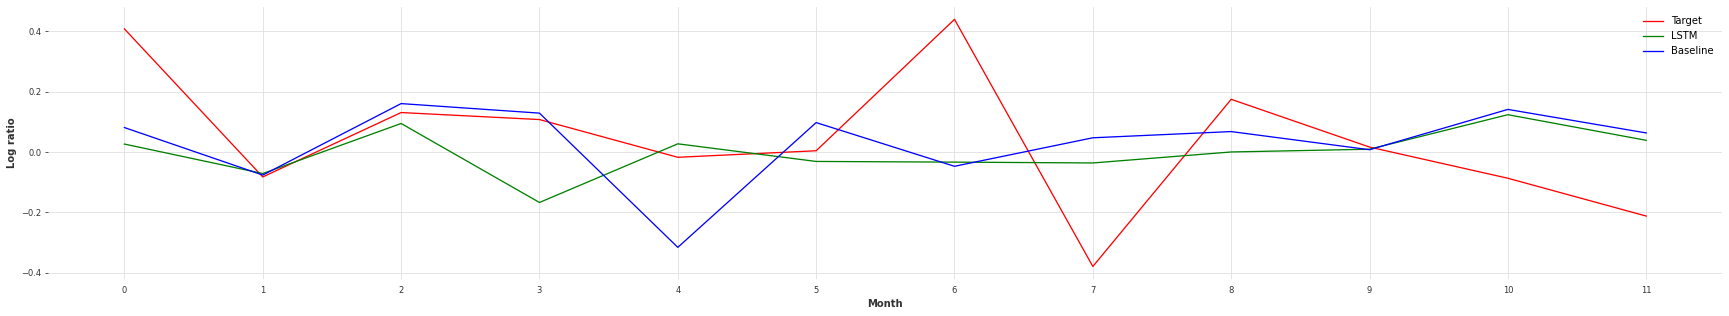

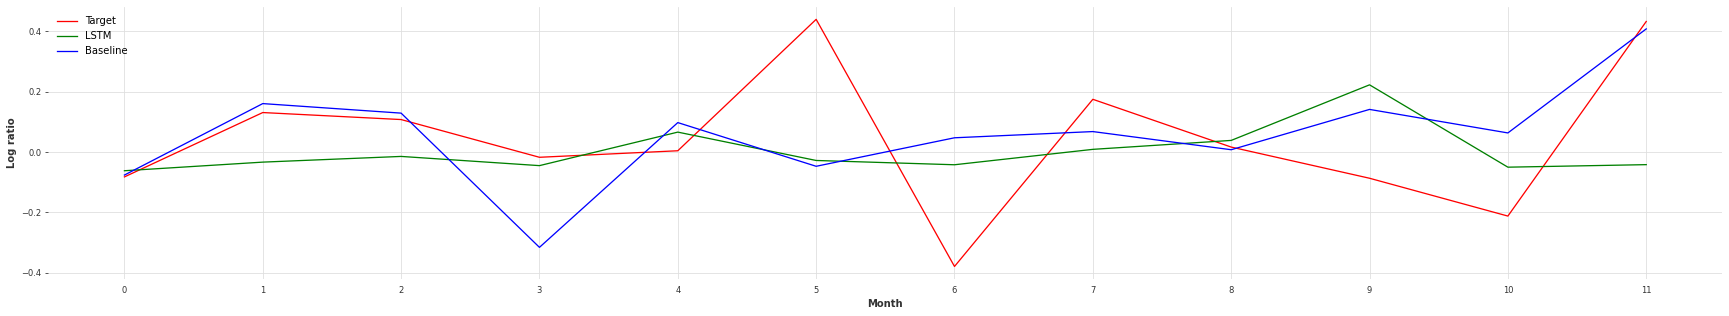

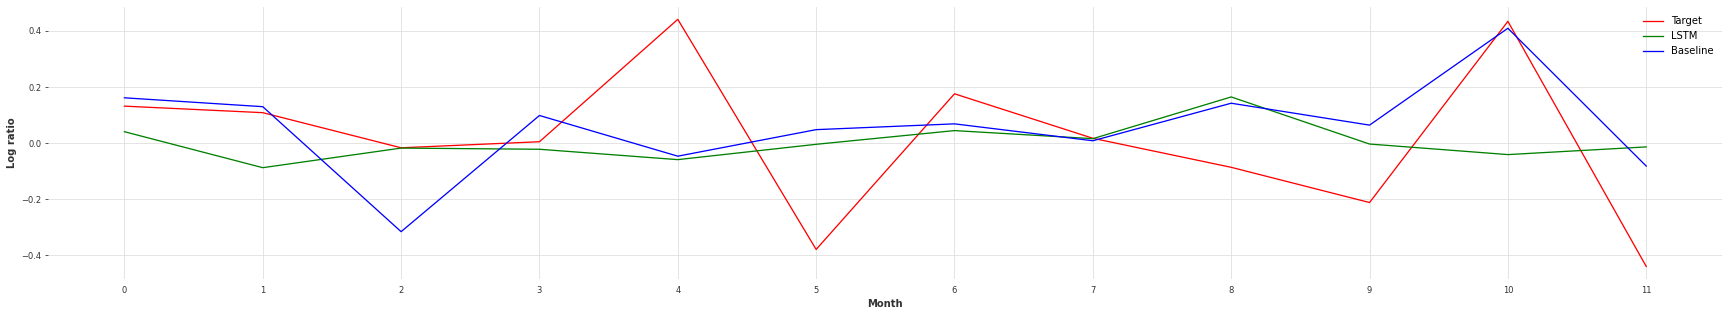

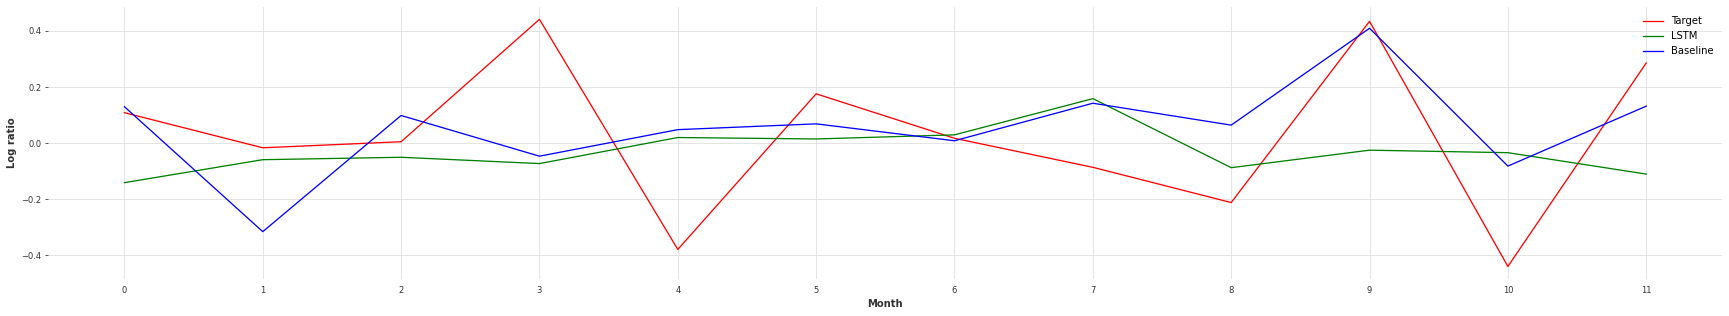

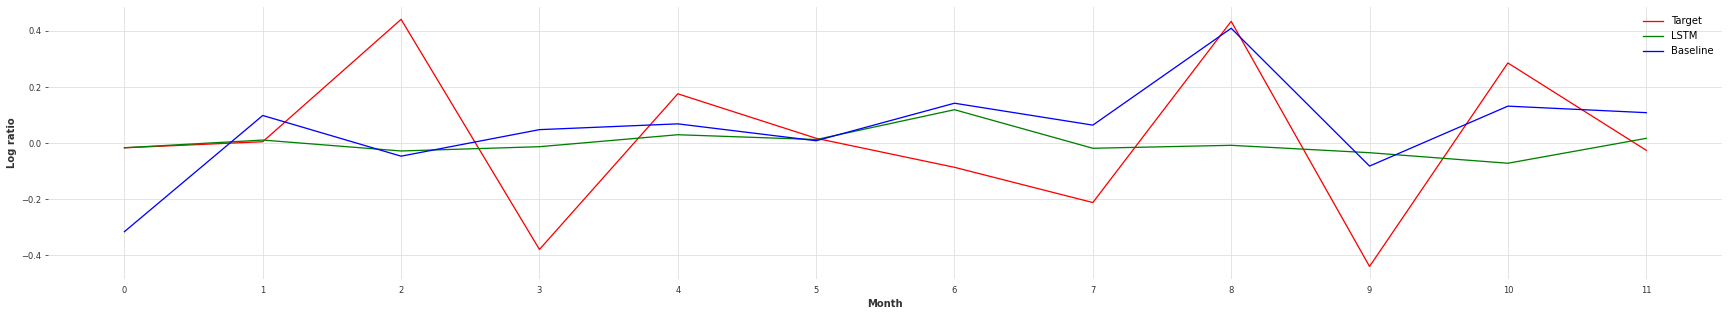

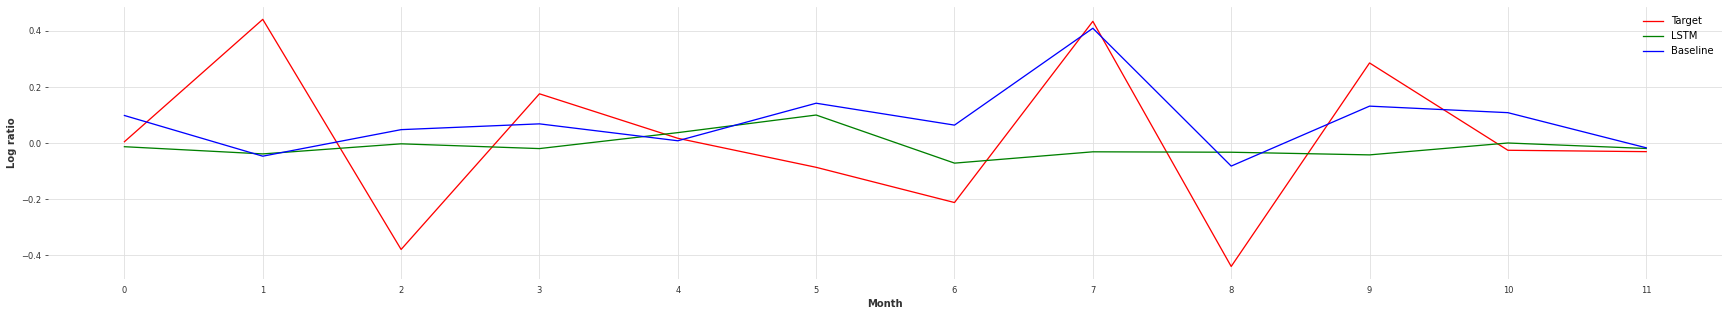

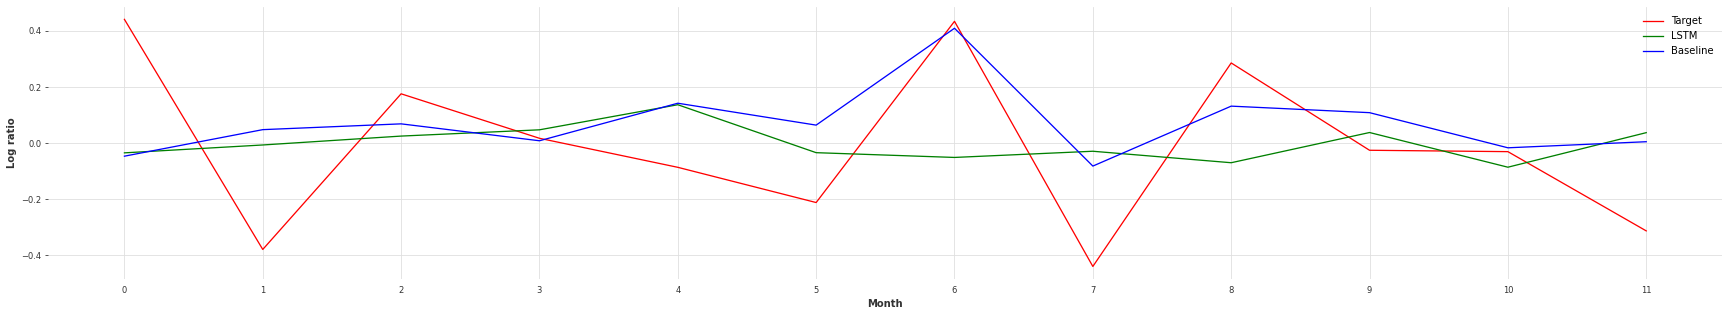

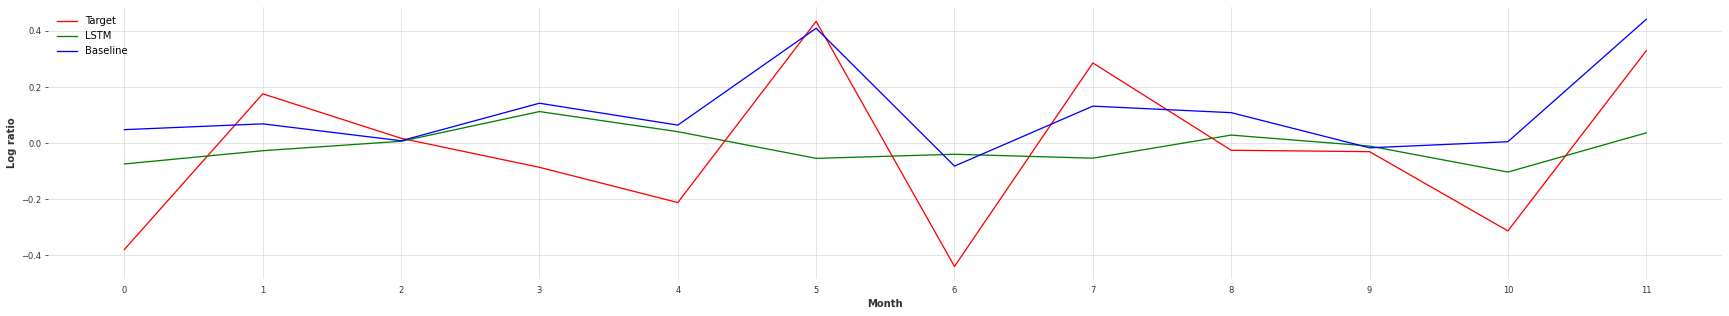

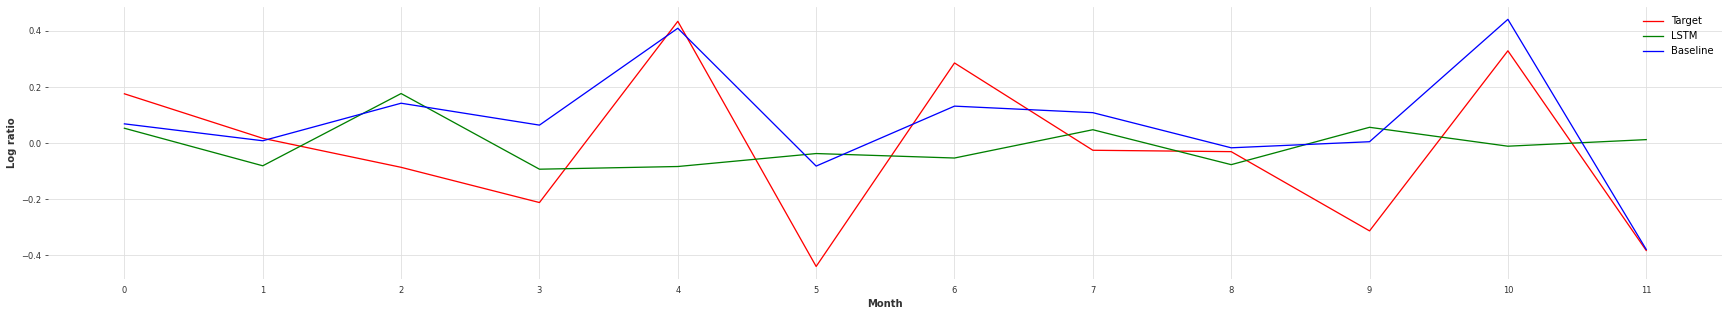

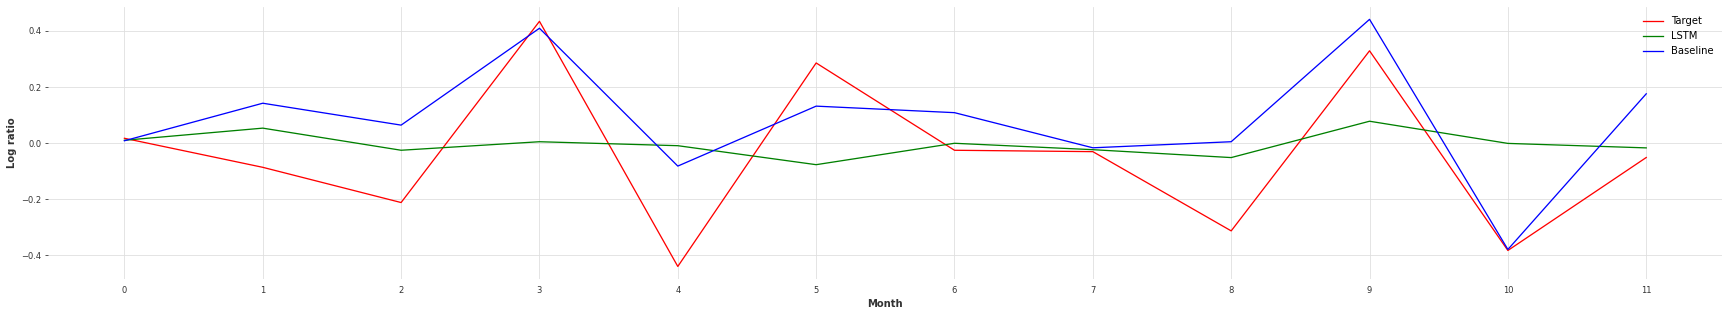

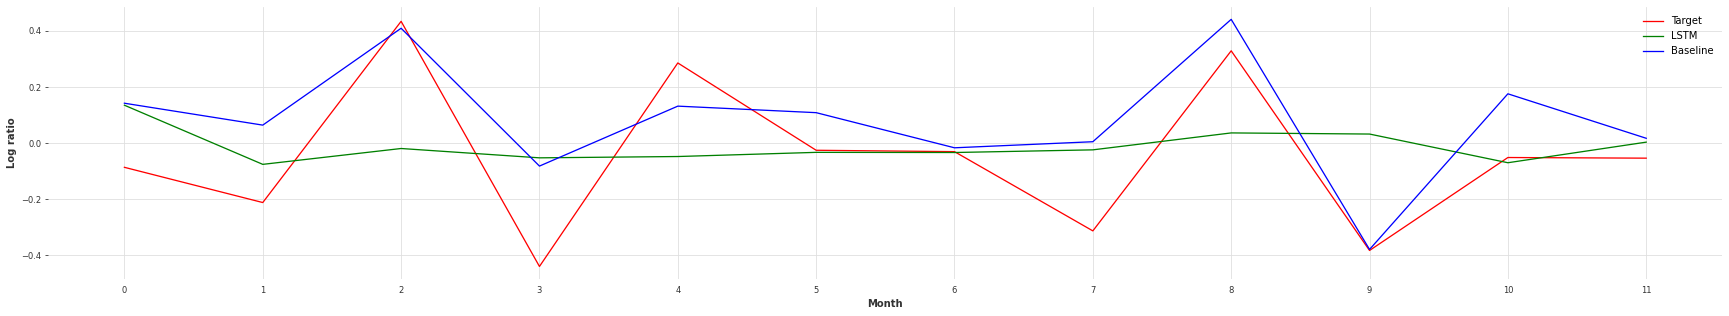

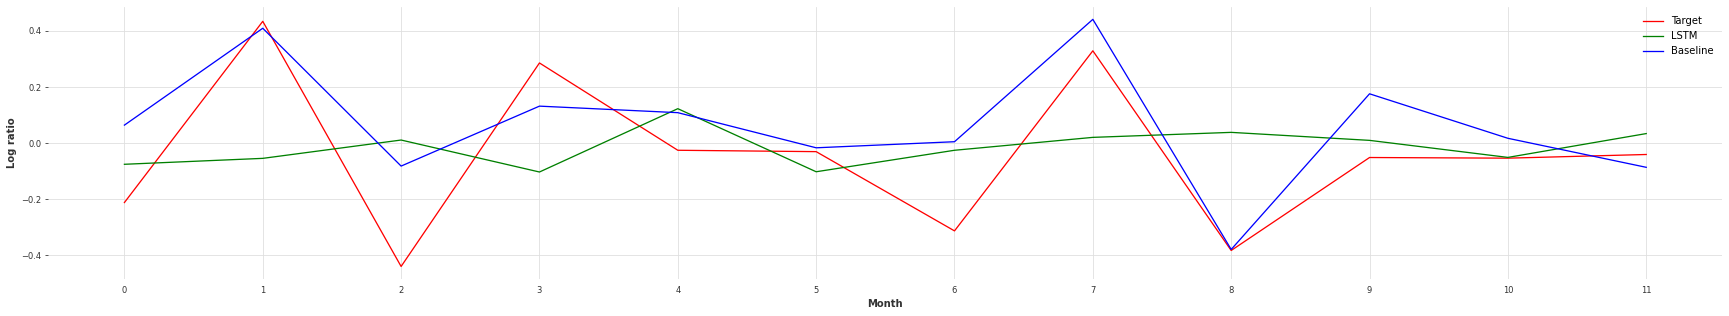

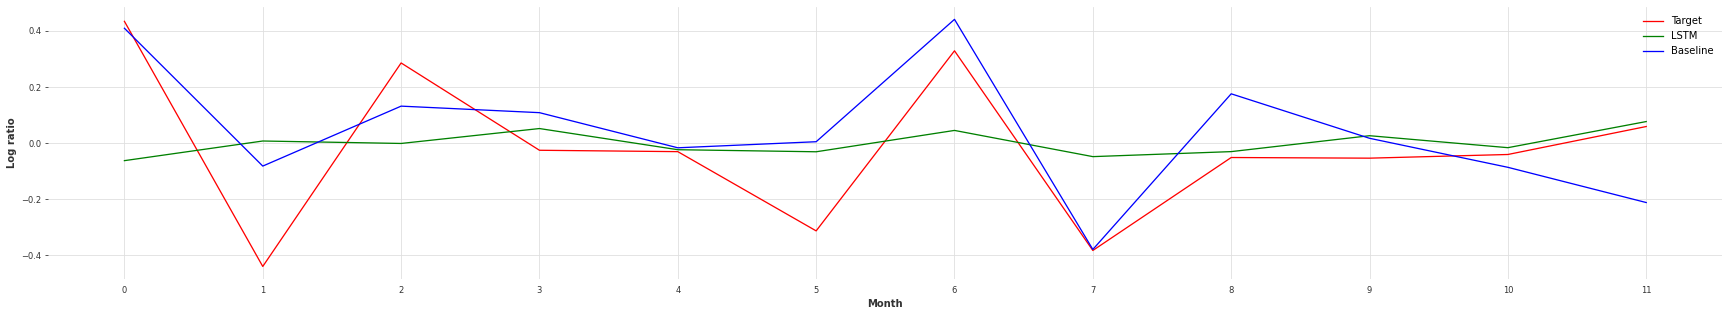

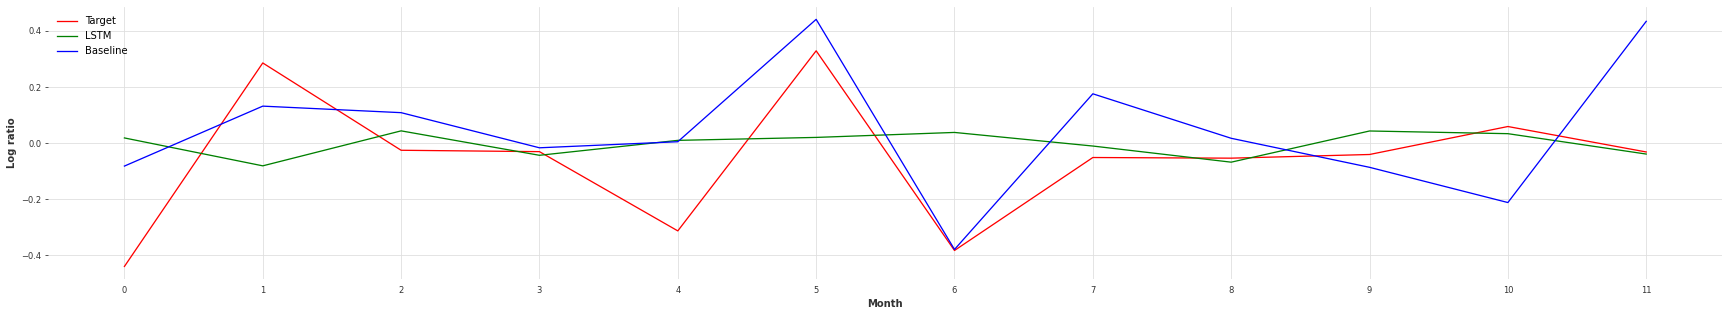

In [ ]:
for sequence in range(X_test_tensors.size(0)):
    # plot prediction using ratios
    plot_prediction_ratios(sequence)

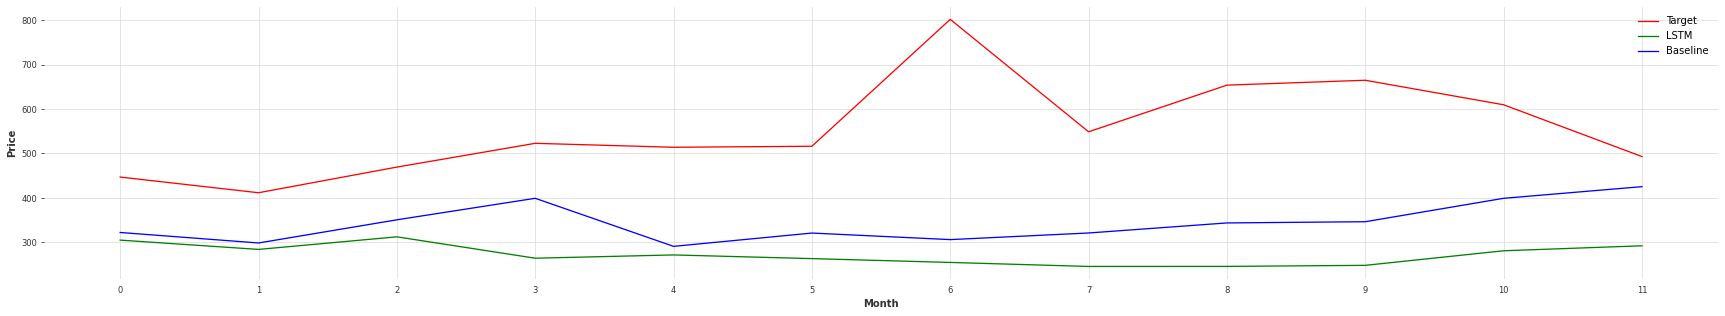

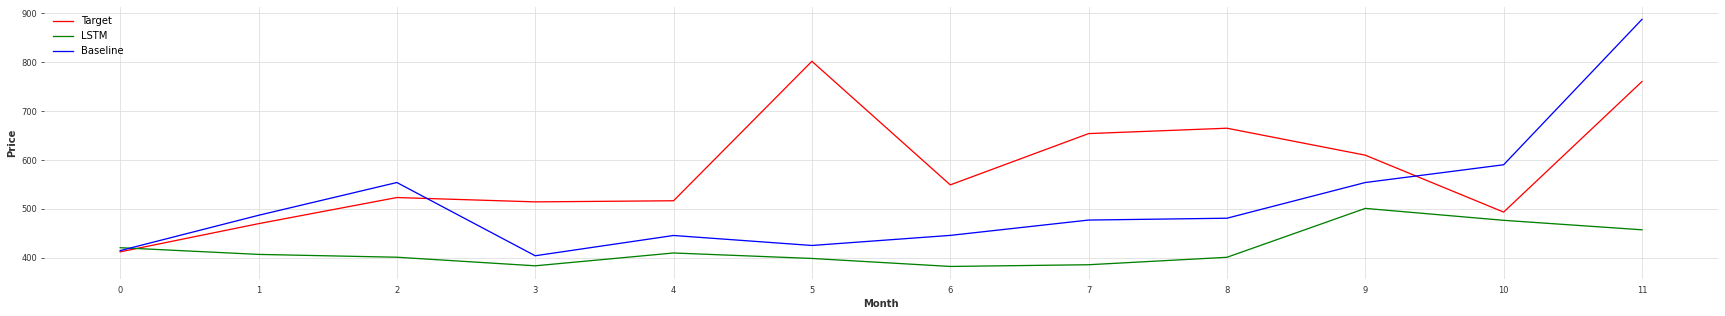

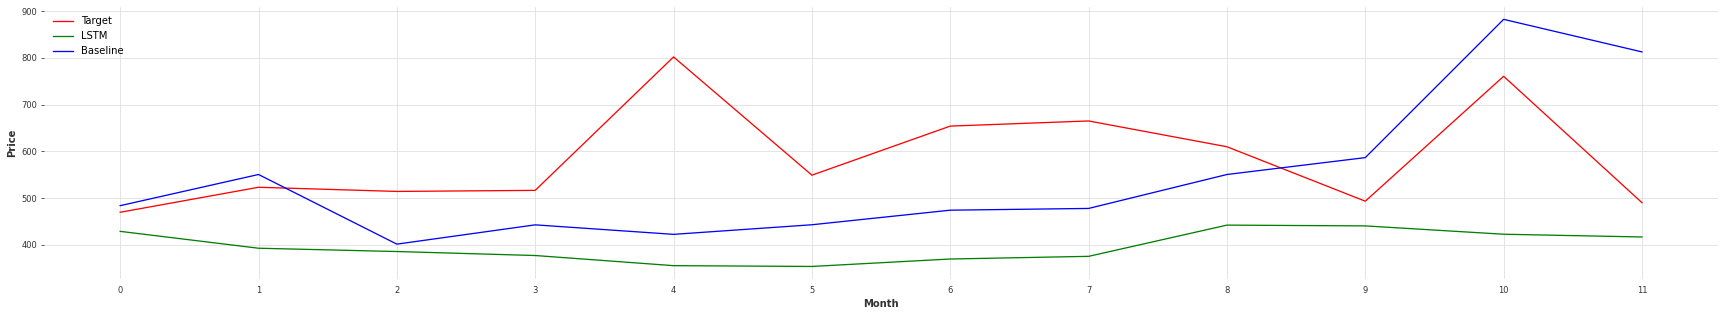

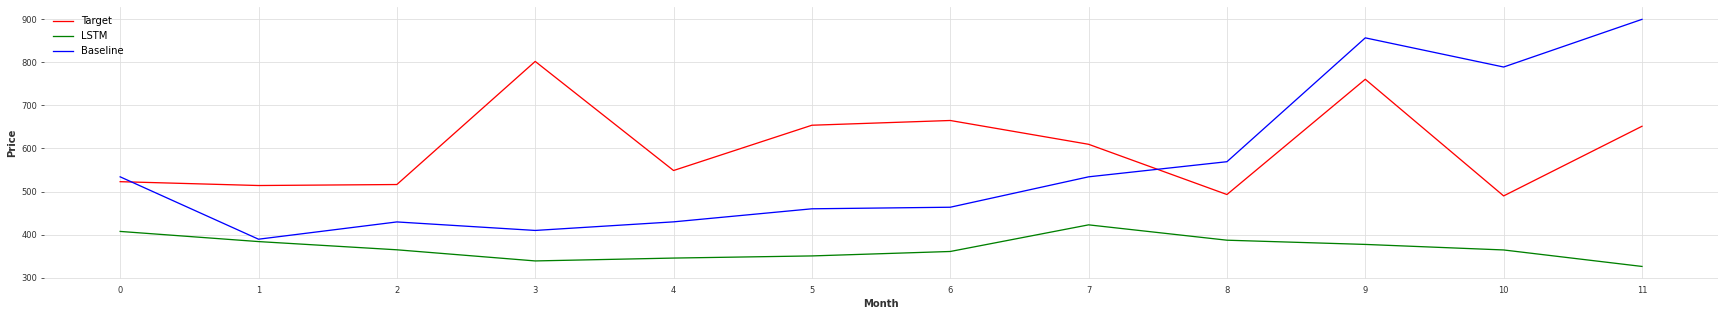

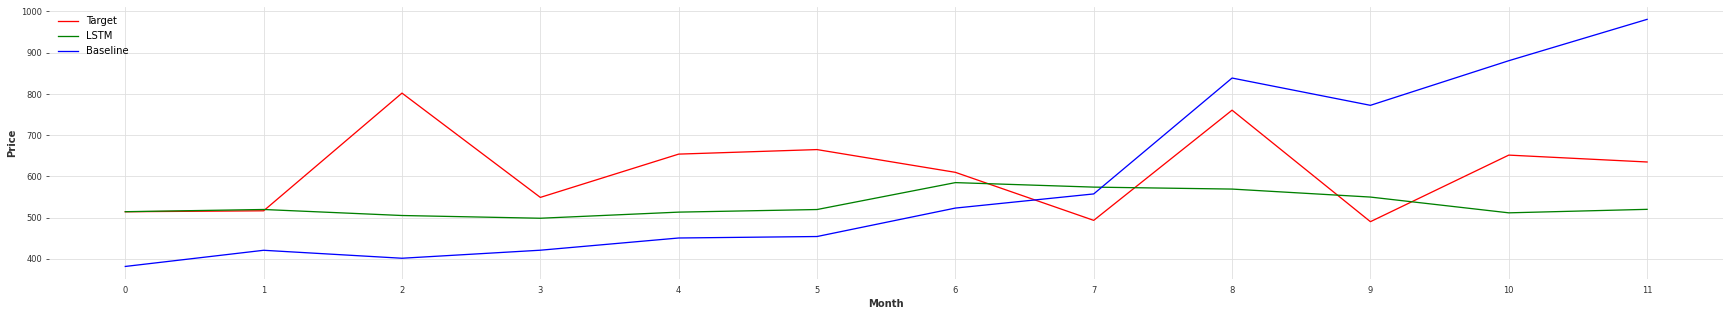

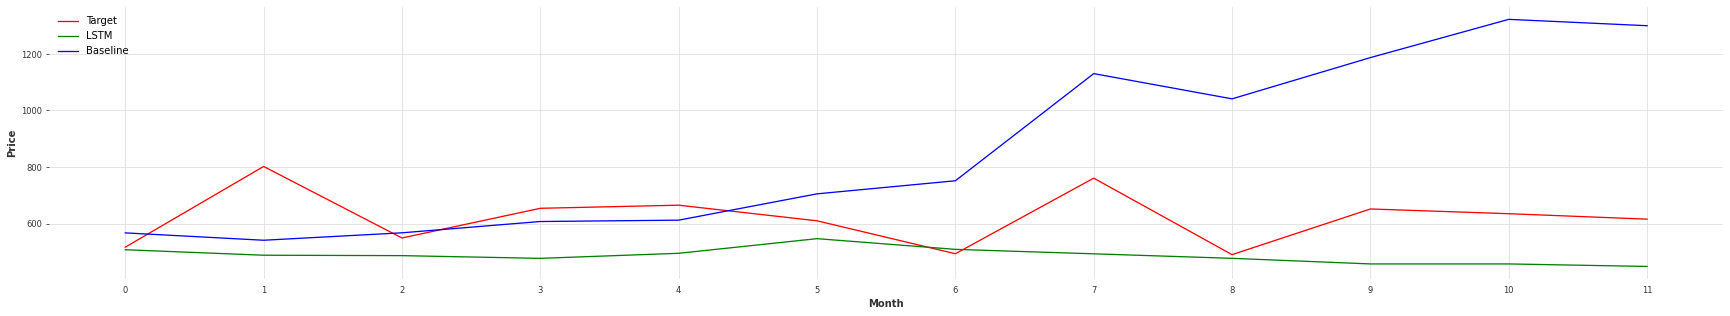

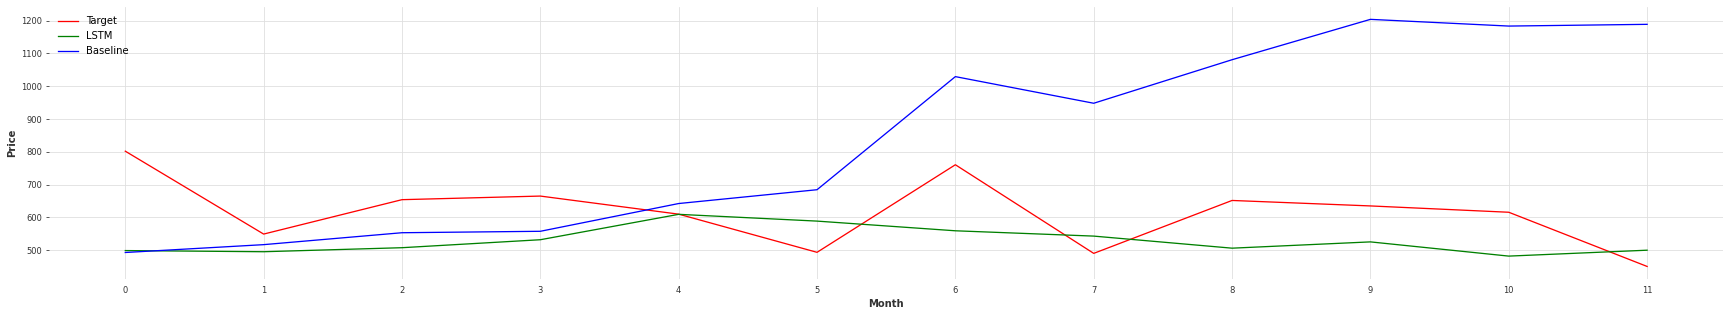

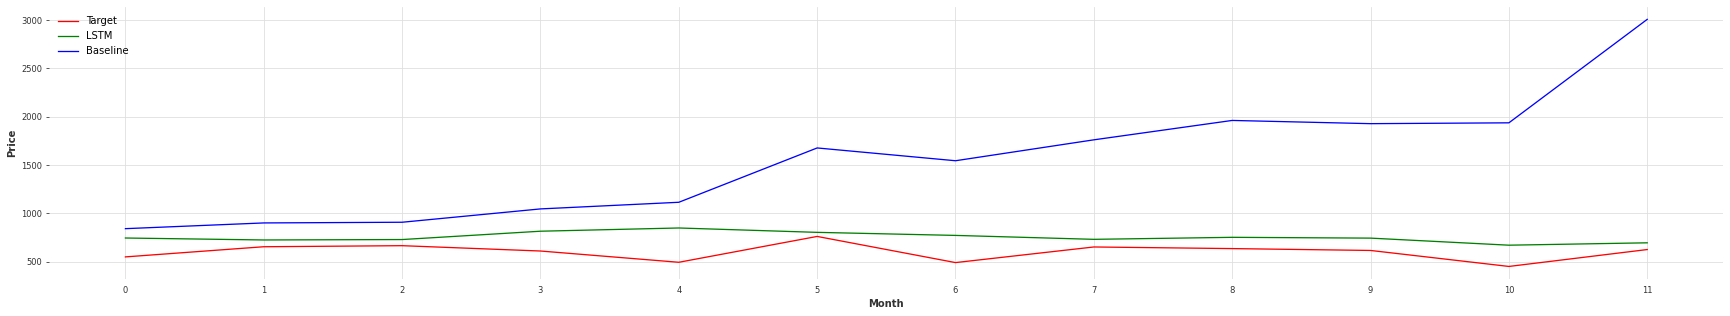

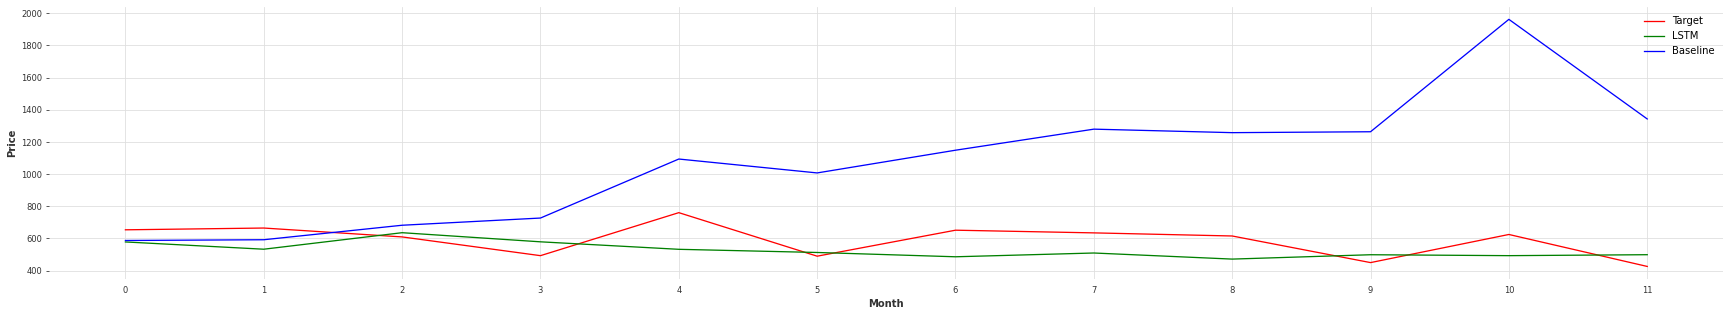

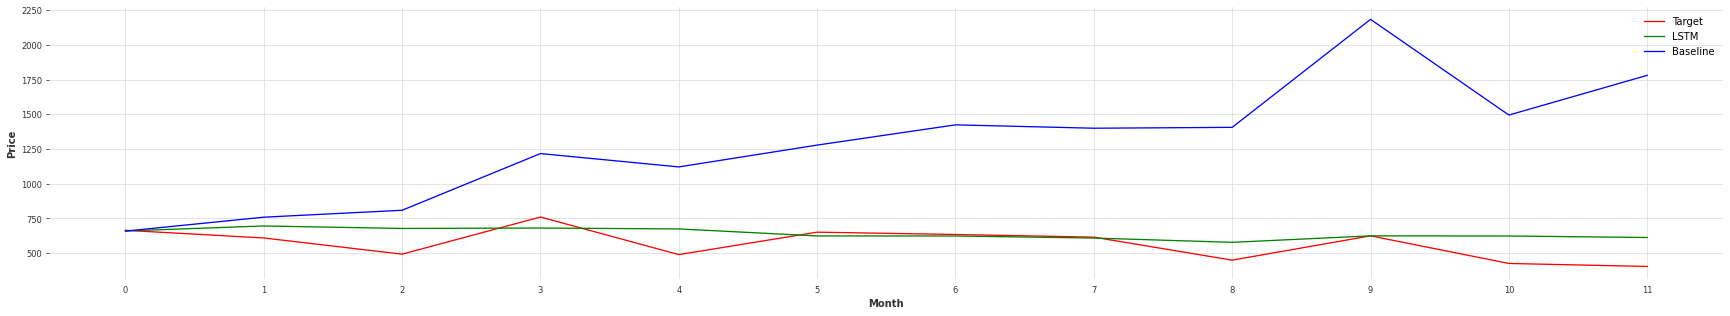

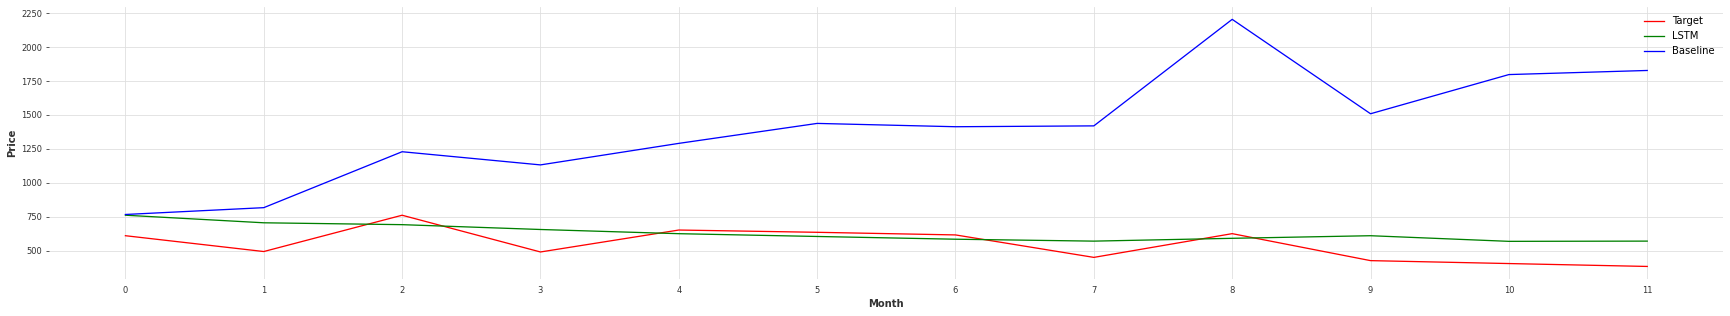

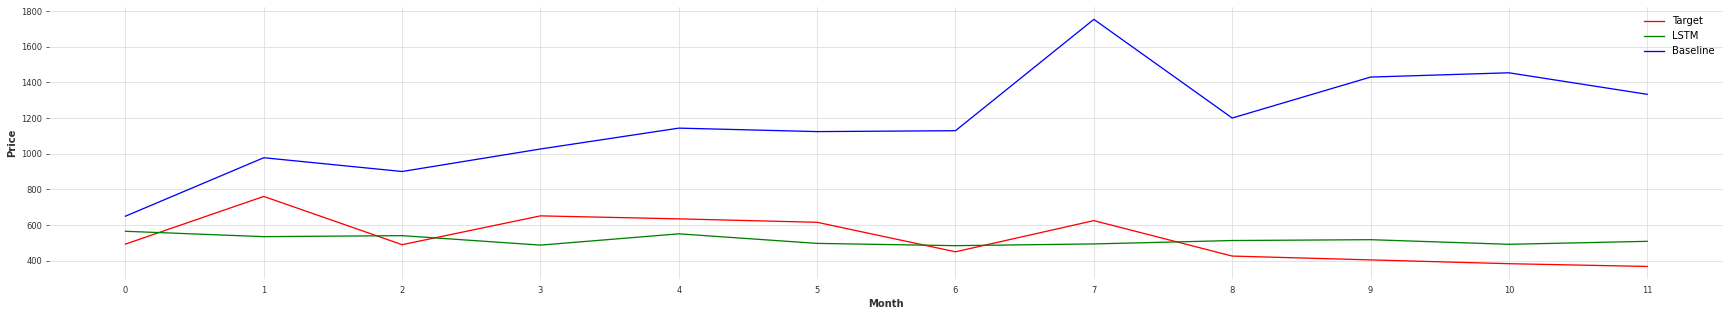

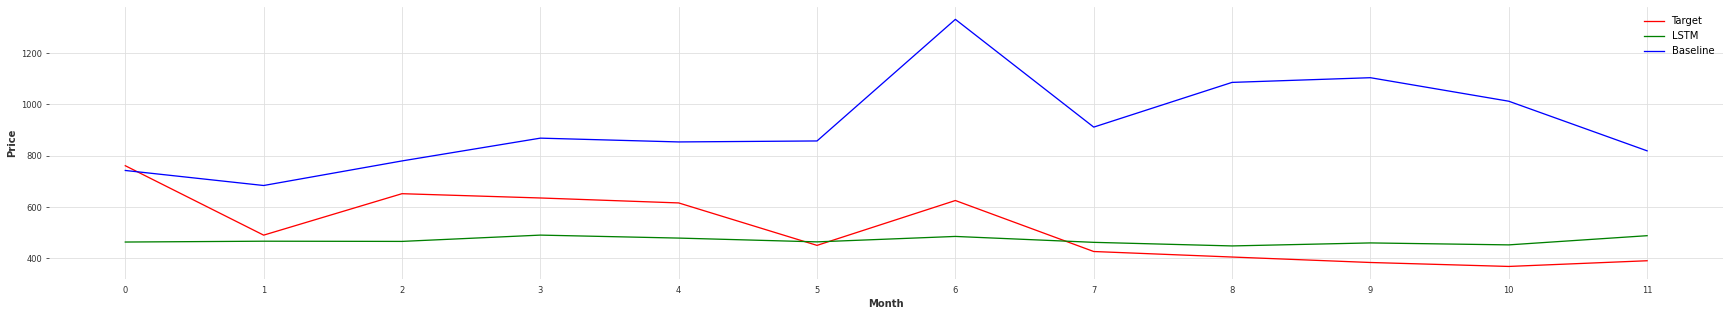

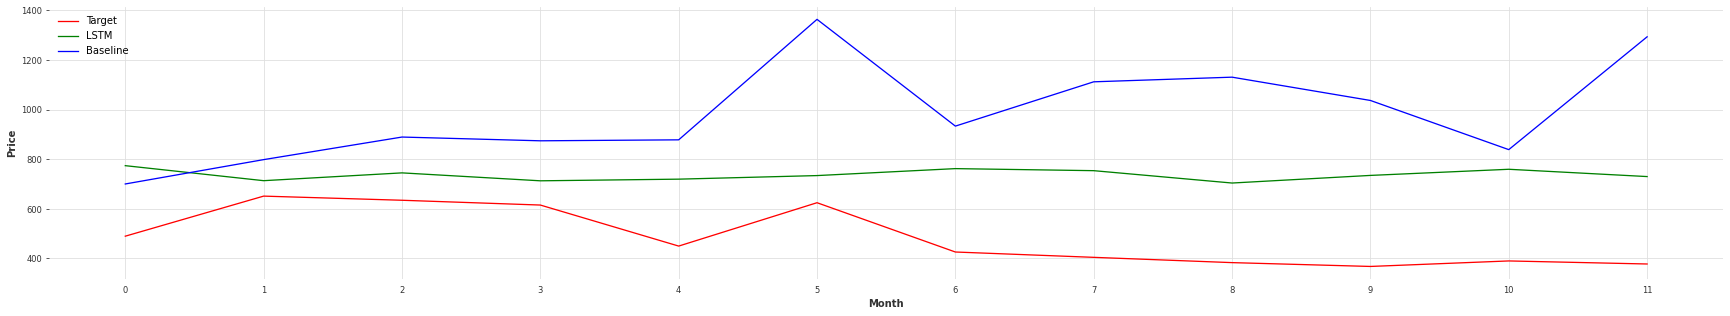

In [ ]:
for sequence in range(X_test_tensors.size(0)):
    # plot prediction using prices
    plot_prediction_prices(sequence)